In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

import colorsys

In [2]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [3]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [4]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [5]:
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean

In [6]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [7]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')

In [8]:
corr_map = maps_voxel_res.numpy()

In [9]:
##################
### Load Atlas ###
##################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

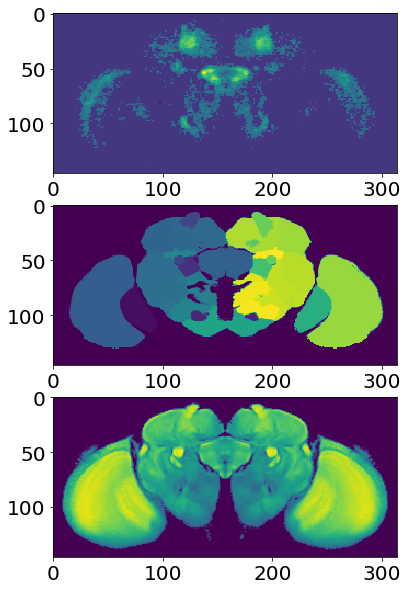

In [10]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(maps_voxel_res[:,:,z,2].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

In [11]:
atlas = atlas.numpy()

In [12]:
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

(-0.5, 313.5, 145.5, -0.5)

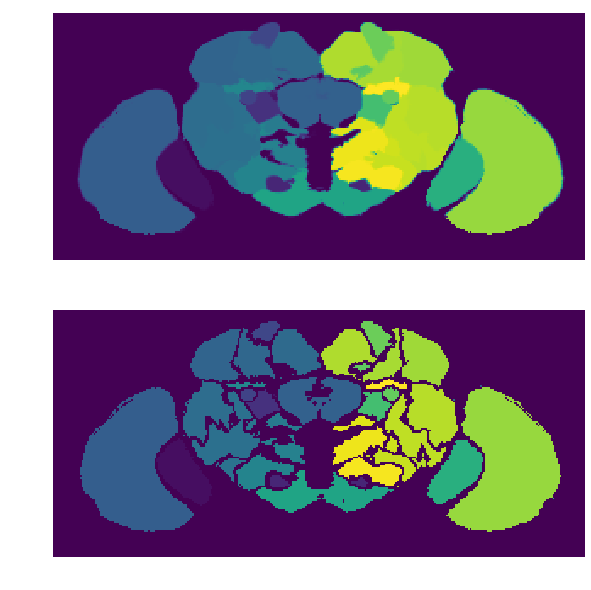

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [15]:
# ####################
# ### Get roi mask ###
# ####################

# mask = np.zeros(atlas_clean.shape)
# mask[np.where(atlas_clean == 26)] = 1

# mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
# mask_dilated = binary_dilation(mask_eroded, iterations=2)

# masked_roi = mask_dilated[...,np.newaxis]*corr_map

# # for plotting
# left_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][0]
# right_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][-1]
# top_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][0]
# bottom_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][-1]

# masked_roi_flat = np.max(masked_roi,axis=2)

In [16]:
# ### Get list of voxels in ROI in RGB
# mask = np.zeros(atlas_clean.shape)
# mask[np.where(atlas_clean == 26)] = 1
# mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
# mask_dilated = binary_dilation(mask_eroded, iterations=2)
# roi_voxels = corr_map[np.where(mask_dilated == 1)]

# ### Convert list to HSV
# hsv_voxels = []
# for i in range(roi_voxels.shape[0]):
#     hsv_voxels.append(colorsys.rgb_to_hsv(*roi_voxels[i]))
# hsv_voxels = np.asarray(hsv_voxels)

In [19]:
roi_counts = {}
for roi in full_group.keys():
    ############ Get voxels in ROI #############

    ### Get list of voxels in ROI in RGB
    mask = np.zeros(atlas_clean.shape)
    mask[np.where(atlas_clean == roi)] = 1
    mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
    mask_dilated = binary_dilation(mask_eroded, iterations=2)
    roi_voxels = corr_map[np.where(mask_dilated == 1)]

    ### Convert list to HSV
    hsv_voxels = []
    blk_cnt=0
    for i in range(roi_voxels.shape[0]):
        if np.sum(roi_voxels[i]) != 0: # exclude black pixels (0,0,0)
            hsv_voxels.append(colorsys.rgb_to_hsv(*roi_voxels[i]))
        else:
            blk_cnt +=1
    hsv_voxels = np.asarray(hsv_voxels)

    ############## PUT IN BINS ###############

    ntheta = 48; dtheta = 360/ntheta;
    nradius = 5; dradius = 10/nradius;

    colors = np.linspace(0,255,ntheta+1)
    colors = [int(i) for i in colors]

    #####################
    ### Make Hue Bins ###
    #####################

    hue_bin_centers = [i/255 for i in colors]
    bin_width = hue_bin_centers[1] - hue_bin_centers[0]
    hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
    hue_bin_starts[0] = 0
    hue_bin_ends = list(np.delete(hue_bin_starts,0))
    hue_bin_ends.append(1)

    #####################
    ### Make Sat Bins ###
    #####################
    sat_bin_starts = [.8,.6,.4,.2,0]
    sat_bin_ends = [1,.8,.6,.4,.2]

    ##############################
    ### Get Hue/Sat Bin Counts ###
    ##############################

    bin_cnts = []

    for sat_bn in range(len(sat_bin_starts)):
        sat_bin = np.where(np.logical_and(sat_bin_starts[sat_bn]<hsv_voxels[:,1],
                                  hsv_voxels[:,1]<=sat_bin_ends[sat_bn]))[0]
        for hue_bn in range(len(hue_bin_starts)):
            hue_bin = np.where(np.logical_and(hue_bin_starts[hue_bn]<=hsv_voxels[:,0],
                                              hsv_voxels[:,0]<hue_bin_ends[hue_bn]))[0]
            bin_cnts.append(len(set(hue_bin) & set(sat_bin)))

    ################ Get bin counts #################
    red_cnt = bin_cnts[0]
    green_cnt = bin_cnts[16]
    blue_cnt = bin_cnts[32]
    rg_cnt = np.sum(bin_cnts[1:16])
    gb_cnt = np.sum(bin_cnts[17:32])
    br_cnt = np.sum(bin_cnts[33:48])
    rgb_cnt = np.sum(bin_cnts[49:])
    
#     roi_counts[roi] = [red_cnt, green_cnt, blue_cnt,
#                        rg_cnt, gb_cnt, br_cnt,
#                        rgb_cnt, blk_cnt]
    
    roi_counts[roi] = [red_cnt, br_cnt, blue_cnt, gb_cnt, green_cnt, rg_cnt, rgb_cnt, blk_cnt]

In [20]:
###########################
### Organize corr types ###
###########################

# roicounts order: [red_cnt, br_cnt, blue_cnt, gb_cnt, green_cnt, rg_cnt, rgb_cnt, blk_cnt]
left_regions = []
for roi in full_left_group.keys():
    left_regions.append([roi_counts[roi][i] for i in [4,3,2,1,0,6,7]]/np.sum(roi_counts[roi])) #green, ..., red, white
left_regions = np.asarray(left_regions)

right_regions = []
for roi in full_right_group.keys():
    right_regions.append([roi_counts[roi][i] for i in [4,3,2,1,0,6,7]]/np.sum(roi_counts[roi])) #green, ..., red, white
right_regions = np.asarray(right_regions)

In [28]:
right_regions.shape

(39, 6)

In [31]:
right_regions[0,:]

array([0.00611291, 0.30420712, 0.37540453, 0.12477526, 0.00755124,
       0.05070119])

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(4,10));

ax[0].barh(list(range(39))[::-1], left_regions[:,2],color='blue')
ax[1].barh(list(range(39))[::-1], right_regions[:,2],color='blue')
ax[0].invert_xaxis()
ax[0].axis('off')

##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
names = names[::-1] #need to swap y-order

ax[1].set_yticks(np.arange(len(full_left_group)));
ax[1].set_yticklabels(names,fontsize=10,ha='center',x=-.17);
# ax[1].spines["right"].set_visible(False)
# ax[1].spines["left"].set_visible(False)
# ax[1].spines["top"].set_visible(False)
# ax[1].spines["bottom"].set_visible(False)
ax[1].tick_params(width=0)
ax[1].set_xticks([])
plt.subplots_adjust(wspace=.5)

ax[0].set_xlim(.6,0)
ax[1].set_xlim(0,.6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

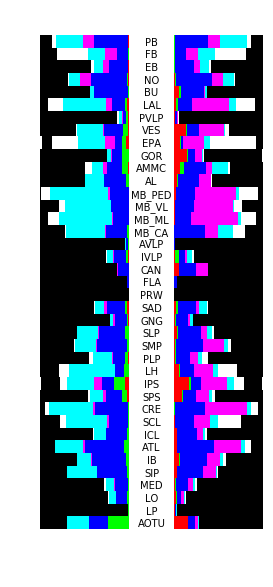

In [62]:
### attempt stacked bar for all types in one plot

fig, ax = plt.subplots(1,2,figsize=(4,10));
y_nums = list(range(39))[::-1]

#LEFT HEMI
#color order: g, gb, b, br, r, rgb, none
color_order = [4,0,2,3,1,5,6] #red, green, blue, magenta, cyan, rgb
colors = [(1,0,0), (0,1,0), (0,0,1), 'magenta', 'cyan', 'w', 'k']
left = np.zeros(39)
for j,color_idx in enumerate(color_order):
    to_plot = left_regions[:,color_idx]
    ax[0].barh(y_nums, to_plot, left=left, color=colors[j], height=1)
    left += to_plot
ax[0].invert_xaxis()
ax[0].axis('off')

#RIGHT HEMI
#color order: g, gb, b, br, r, rgb, none
left = np.zeros(39)
for j,color_idx in enumerate(color_order):
    to_plot = right_regions[:,color_idx]
    ax[1].barh(y_nums, to_plot, left=left, color=colors[j], height=1)
    left += to_plot

##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
names = names[::-1] #need to swap y-order

ax[1].set_yticks(np.arange(len(full_left_group)));
ax[1].set_yticklabels(names,fontsize=10,ha='center',x=-.17);
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)
ax[1].tick_params(width=0)
ax[1].set_xticks([])
plt.subplots_adjust(wspace=.5)

ax[0].set_xlim(1,0)
ax[1].set_xlim(0,1)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight', transparent=True)

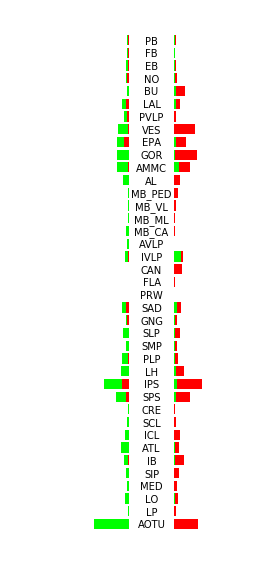

In [24]:
fig, ax = plt.subplots(1,2,figsize=(4,10));

y_nums = list(range(39))[::-1]
l_hemi_green = left_regions[:,0]
l_hemi_red = left_regions[:,4]

ax[0].barh(y_nums, l_hemi_red,color='red')
ax[0].barh(y_nums, l_hemi_green,left=l_hemi_red,color=(0,1,0))
ax[0].invert_xaxis()
ax[0].axis('off')

r_hemi_green = right_regions[:,0]
r_hemi_red = right_regions[:,4]


ax[1].barh(y_nums, r_hemi_green,color=(0,1,0))
ax[1].barh(y_nums, r_hemi_red,left=r_hemi_green,color='red')

##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
names = names[::-1] #need to swap y-order

ax[1].set_yticks(np.arange(len(full_left_group)));
ax[1].set_yticklabels(names,fontsize=10,ha='center',x=-.17);
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)
ax[1].tick_params(width=0)
ax[1].set_xticks([])
plt.subplots_adjust(wspace=.5)

ax[0].set_xlim(.6,0)
ax[1].set_xlim(0,.6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

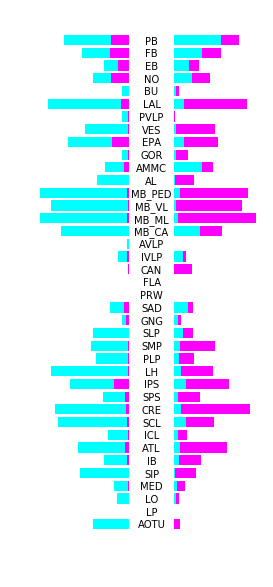

In [213]:
fig, ax = plt.subplots(1,2,figsize=(4,10));

y_nums = list(range(39))[::-1]
l_hemi_green = left_regions[:,1]
l_hemi_red = left_regions[:,3]

ax[0].barh(y_nums, l_hemi_red,color='magenta')
ax[0].barh(y_nums, l_hemi_green,left=l_hemi_red,color='cyan')
ax[0].invert_xaxis()
ax[0].axis('off')

r_hemi_green = right_regions[:,1]
r_hemi_red = right_regions[:,3]


ax[1].barh(y_nums, r_hemi_green,color='cyan')
ax[1].barh(y_nums, r_hemi_red,left=r_hemi_green,color='magenta')

##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
names = names[::-1] #need to swap y-order

ax[1].set_yticks(np.arange(len(full_left_group)));
ax[1].set_yticklabels(names,fontsize=10,ha='center',x=-.17);
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)
ax[1].tick_params(width=0)
ax[1].set_xticks([])
plt.subplots_adjust(wspace=.5)

ax[0].set_xlim(.6,0)
ax[1].set_xlim(0,.6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

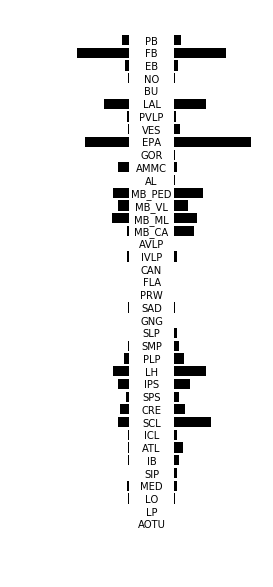

In [225]:
fig, ax = plt.subplots(1,2,figsize=(4,10));

ax[0].barh(list(range(39))[::-1], left_regions[:,-1],color='k')
ax[1].barh(list(range(39))[::-1], right_regions[:,-1],color='k')
ax[0].invert_xaxis()
ax[0].axis('off')

##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
names = names[::-1] #need to swap y-order

ax[1].set_yticks(np.arange(len(full_left_group)));
ax[1].set_yticklabels(names,fontsize=10,ha='center',x=-.17);
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)
ax[1].tick_params(width=0)
ax[1].set_xticks([])
plt.subplots_adjust(wspace=.5)

ax[0].set_xlim(.6,0)
ax[1].set_xlim(0,.6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [157]:
len(l_hemi_green)

39

In [159]:
len(names)

39

In [22]:
to_sum = []
for roi in full_group.keys():
    to_sum.append(roi_counts[roi])

In [28]:
brainwide_dtypes = np.sum(np.asarray(to_sum),axis=0)

for i in range(8):
    print(brainwide_dtypes[i]/np.sum(brainwide_dtypes))

0.017789022369783174
0.06109614345025618
0.15467782565970178
0.10307040101901684
0.01691357835552219
0.0009651770257227337
0.037340970123284405
0.6081468819967127


In [19]:
print(
    red_cnt, 
    green_cnt,
    blue_cnt,
    rg_cnt,
    gb_cnt,
    br_cnt,
    rgb_cnt,
    blk_cnt)

714 2 339 0 7 155 2 3149


In [58]:
red_cnt+green_cnt+blue_cnt+rg_cnt+gb_cnt+br_cnt+rgb_cnt+blk_cnt

12480

In [61]:
roi_counts

{4: [18, 9, 420, 0, 125, 125, 9, 334],
 5: [0, 4, 90, 0, 13, 0, 0, 148],
 8: [147, 211, 1051, 26, 3590, 398, 1242, 686],
 26: [52, 83, 1638, 0, 2399, 1561, 4344, 2403],
 31: [155, 318, 460, 43, 515, 144, 217, 12341],
 54: [28, 4, 127, 0, 7, 10, 0, 284],
 56: [193, 135, 1173, 3, 511, 3098, 1592, 685],
 76: [90, 35, 205, 26, 26, 74, 126, 9227]}

In [127]:
flat = []
for roi in roi_counts.keys():
    flat.append(roi_counts[roi][:-1]/np.sum(roi_counts[roi]))
flat = np.asarray(flat)

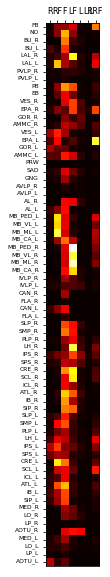

In [129]:
y_types = ['R', 'RF', 'F', 'LF', 'L', 'LR', 'LRF']

fig, ax = plt.subplots(figsize=(10,10));
im = ax.imshow(flat,cmap='hot');

ax.set_yticks(np.arange(len(full_group)));
ax.set_xticks(np.arange(len(y_types)));
ax.set_yticklabels(full_group.values());
ax.set_xticklabels(y_types);

plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=6, rotation_mode="anchor");
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), fontsize=8);

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [162]:
group

{4: 'NO', 6: 'PB', 9: 'SAD', 23: 'EB', 26: 'FB', 49: 'GNG', 50: 'PRW'}

In [177]:
[roi_counts[roi][i] for i in [0,1,2,3,4,6]]

[0, 0, 90, 13, 4, 0]

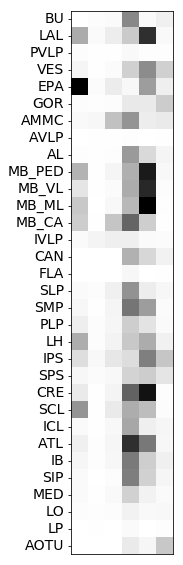

In [20]:
flat = []
group = left_group

for roi in group.keys():
    #flat.append([roi_counts[roi][i] for i in [0,1,2,3,4,6]]/np.sum(roi_counts[roi]))
    flat.append([roi_counts[roi][i] for i in [6,4,3,2,1,0]]/np.sum(roi_counts[roi]))

flat = np.asarray(flat)

y_types = ['R', 'RF', 'F', 'LF', 'L', 'LR', 'LRF']

fig, ax = plt.subplots(figsize=(10,10));
im = ax.imshow(flat,cmap='Greys',vmin=0,vmax=.5);

ax.set_yticks(np.arange(len(group)));
ax.set_xticks([]);
#ax.set_yticklabels([i for i in group.values()]);
ax.set_yticklabels(['_'.join(i.split('_')[:-1]) for i in group.values()]);

#ax.set_xticklabels(y_types);

plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=14, rotation_mode="anchor");
#ax.xaxis.tick_top()
#plt.setp(ax.get_xticklabels(), fontsize=8);

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

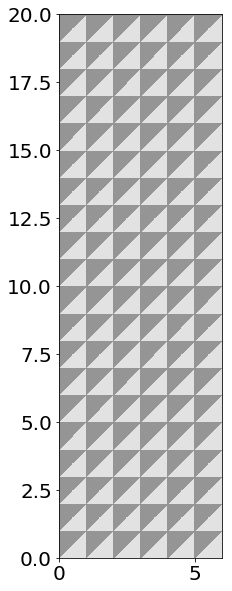

In [20]:
def trianglematrix(upper_triangle, lower_triangle, ax=None, triplotkw={},tripcolorkw={}):
    right=lower_triangle
    left=lower_triangle
    bottom=upper_triangle
    top=upper_triangle
    
    if not ax: ax=plt.gca()
    n = left.shape[0]; m=left.shape[1]

    a = np.array([[0,0],[0,1],[.5,.5],[1,0],[1,1]])
    tr = np.array([[0,1,2], [0,2,3],[2,3,4],[1,2,4]])
    tr = np.array([[0,2,3],[0,1,2],[2,3,4],[1,2,4]]) # swaping first and 2nd sets somehow makes edges better


    A = np.zeros((n*m*5,2))
    Tr = np.zeros((n*m*4,3))

    for i in range(n):
        for j in range(m):
            k = i*m+j
            A[k*5:(k+1)*5,:] = np.c_[a[:,0]+j, a[:,1]+i]
            Tr[k*4:(k+1)*4,:] = tr + k*5

    C = np.c_[ left.flatten(), bottom.flatten(), 
              right.flatten(), top.flatten()   ].flatten()

    triplot = ax.triplot(A[:,0], A[:,1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:,0], A[:,1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor

upper_triangle = np.ones((20,6))*.5
lower_triangle = np.ones((20,6))*.2
fig, ax=plt.subplots(figsize=(10,10))
trianglematrix(upper_triangle, lower_triangle, ax=ax,
             triplotkw={"color":"k", "lw":0},
             tripcolorkw={"cmap": "Greys", "vmin": "0", "vmax": "1"}) 
ax.margins(0)
ax.set_aspect("equal")

In [74]:
flat.shape

(32, 6)

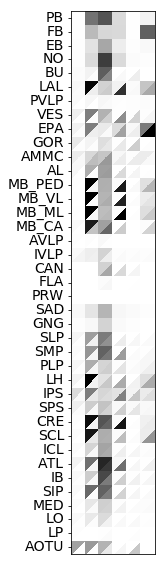

In [21]:
###########################
### Organize corr types ###
###########################

# roicounts order: [red_cnt, br_cnt, blue_cnt, gb_cnt, green_cnt, rg_cnt, rgb_cnt, blk_cnt]
left_regions = []
for roi in full_left_group.keys():
    left_regions.append([roi_counts[roi][i] for i in [4,3,2,1,0,6]]/np.sum(roi_counts[roi])) #green, ..., red, white
left_regions = np.asarray(left_regions)

right_regions = []
for roi in full_right_group.keys():
    right_regions.append([roi_counts[roi][i] for i in [4,3,2,1,0,6]]/np.sum(roi_counts[roi])) #green, ..., red, white
right_regions = np.asarray(right_regions)

############
### PLOT ###
############

upper_triangle = left_regions[::-1,:] #need to swap y-order
lower_triangle = right_regions[::-1,:] #need to swap y-order
fig, ax=plt.subplots(figsize=(10,10))
trianglematrix(upper_triangle, lower_triangle, ax=ax,
             triplotkw={"color":"k", "lw":0},
             tripcolorkw={"cmap": "Greys", "vmin": "0", "vmax": "0.5"}) 
ax.margins(0)
ax.set_aspect("equal")

##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
names = names[::-1] #need to swap y-order
        
ax.set_yticks([i+.5 for i in np.arange(len(names))]);
ax.set_xticks([]);
ax.set_yticklabels(names);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=14, rotation_mode="anchor");

### SAVE ###

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [16]:
full_right_group = {
6: 'PB',
26: 'FB',
23: 'EB',
4: 'NO',
54: 'BU_L',
56: 'LAL_L',
76: 'PVLP_L',
####################
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
####################
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
75: 'AVLP_L',
77: 'IVLP_L',
57: 'CAN_L',
67: 'FLA_L',
50: 'PRW',
9: 'SAD',
49: 'GNG', 
####################
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
###################
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L' 
}

full_left_group = {
6: 'PB',
26: 'FB',
23: 'EB',
4: 'NO',
5: 'BU_R',
8: 'LAL_R',
31: 'PVLP_R',
##################
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
##################
24: 'AL_R',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
30: 'AVLP_R',
32: 'IVLP_R',
10: 'CAN_R',
20: 'FLA_R',
50: 'PRW',
9: 'SAD',
49: 'GNG',
###################    
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',
###################
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R'
}

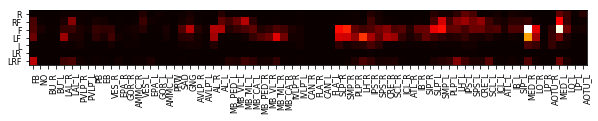

In [107]:
y_types = ['R', 'RF', 'F', 'LF', 'L', 'LR', 'LRF']

fig, ax = plt.subplots(figsize=(10,10));
im = ax.imshow(flat.T,cmap='hot');

ax.set_xticks(np.arange(len(full_group)));
ax.set_yticks(np.arange(len(y_types)));
ax.set_xticklabels(full_group.values());
ax.set_yticklabels(y_types);

plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=8, rotation_mode="anchor");
plt.setp(ax.get_yticklabels(), fontsize=8);

In [86]:
##################
### ROI GROUPS ###
##################

midline_group = {
26: 'FB',
4: 'NO',
6: 'PB',
23: 'EB',
50: 'PRW',
9: 'SAD',
49: 'GNG'}

right_group = { #SWAPING LEFT AND RIGHT SINCE ATLAS IS FLIPPED. I KNOW THIS.
54: 'BU_L',
56: 'LAL_L',
76: 'PVLP_L',
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
75: 'AVLP_L',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
77: 'IVLP_L',
57: 'CAN_L',
67: 'FLA_L',
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L'
}

left_group = {
5: 'BU_R',
8: 'LAL_R',
31: 'PVLP_R',
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
30: 'AVLP_R',
24: 'AL_R',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
10: 'CAN_R',
20: 'FLA_R',
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R'
}

In [18]:
##################
### ROI GROUPS ###
##################

full_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L',
6: 'PB',
23: 'EB',
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L',
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',#####
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R',
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L',
}

In [18]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}



anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}